In [36]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
from typing import Union, Any ,List, Dict


pd.set_option("display.max_colwidth", 120)

## Loading the downloaded JSON File to Pandas DataFrame

In [37]:
def file_exists(filepath: str | Path) -> bool:
    """
    Check if a file exists at the given path.

    Raises:
        FileNotFoundError: if the file is missing.
    Returns:
        bool: True if file exists.
    """
    doc_path = Path(filepath).resolve()
    if not doc_path.exists():
        raise FileNotFoundError(
            f"Dataset not found at {doc_path}. Run load_faq_data.py first or check the path."
        )
    print(f"File found at {doc_path}")
    return True


In [38]:
DATA_DIR = Path.cwd() / "data"
DATA_PATH = DATA_DIR / "documents.json"

In [39]:
print("DATA_DIR:", DATA_DIR)

DATA_DIR: /home/daudf/llm-zoomcamp-2025-daudjan/01-intro-rag/data


In [40]:
docs_path = Path(DATA_PATH)

file_exists(docs_path)

File found at /home/daudf/llm-zoomcamp-2025-daudjan/01-intro-rag/data/documents.json


True

In [41]:
def load_json(filepath: Union[str, Path]) -> list[dict]:
    """Read a JSON file and return parsed Python object."""
    with open(filepath, "r", encoding="utf-8") as f:
        return json.load(f)

In [42]:
data = load_json(docs_path)

In [43]:
def flatten_json_to_df(data: List[Dict[str, Any]]) -> pd.DataFrame:
    """
    Flatten the FAQ JSON structure into a Pandas DataFrame.

    Args:
        data (List[Dict[str, Any]]): Parsed JSON object

    Returns:
        pd.DataFrame: Flattened DataFrame with columns: course, section, question, text.
    """
    records: List[Dict[str, str]] = []

    for item in data:
        course = item.get("course")
        for doc in item.get("documents", []):
            records.append({
                "course": course,
                "section": doc.get("section"),
                "question": doc.get("question"),
                "text": doc.get("text"),
            })

    return pd.DataFrame(records)


In [44]:
df = flatten_json_to_df(data)
df.head()

,course,section,question,text
0,data-engineering-zoomcamp,General course-related questions,Course - When will the course start?,The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the cours...
1,data-engineering-zoomcamp,General course-related questions,Course - What are the prerequisites for this course?,GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites
2,data-engineering-zoomcamp,General course-related questions,Course - Can I still join the course after the start date?,"Yes, even if you don't register, you're still eligible to submit the homeworks.\nBe aware, however, that there will ..."
3,data-engineering-zoomcamp,General course-related questions,Course - I have registered for the Data Engineering Bootcamp. When can I expect to receive the confirmation email?,You don't need it. You're accepted. You can also just start learning and submitting homework without registering. It...
4,data-engineering-zoomcamp,General course-related questions,Course - What can I do before the course starts?,You can start by installing and setting up all the dependencies and requirements:\nGoogle cloud account\nGoogle Clou...


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   course    948 non-null    object
 1   section   948 non-null    object
 2   question  948 non-null    object
 3   text      948 non-null    object
dtypes: object(4)
memory usage: 29.8+ KB


FAQ Dataset Processing Summary

- **Loaded** the raw FAQ dataset (`documents.json`)
- **Flattened** nested structures into a tabular format using `flatten_json_to_df()`
- **Verified** that each record now contains the following fields:
  - `course`
  - `section`
  - `question`
  - `text`


---

##  TF-IDF Vectorization

**Goal:**  
Understand how text data is turned into numerical vectors that a retrieval system can compare.

We'll start with a simple **CountVectorizer** to observe raw word counts,  
then extend it to **TfidfVectorizer** to apply weighting based on term importance.

**Key Concepts:**
- **CountVectorizer** → frequency only  
- **TF-IDF (Term Frequency × Inverse Document Frequency)** → frequency + importance  
- **Cosine Similarity** → measures how similar two vectors (documents) are in direction

---




-  `CountVectorizer` 


In [46]:
sample_docs = df["question"].dropna().sample(5, random_state=42).tolist()

for i,q in enumerate(sample_docs, 1):
    print(f"Question {i}:", q)

Question 1: How to download CSV data via Jupyter NB and the Kaggle API, for one seamless experience
Question 2: Get an error ‘Unable to locate credentials’ after running localstack with kinesis
Question 3: GCP VM -  connect to host port 22 no route to host
Question 4: Docker-Compose - docker-compose still not available after changing .bashrc
Question 5: How to troubleshoot issues


In [47]:
vectorizer = CountVectorizer(stop_words="english")

vectorizer.fit(sample_docs)

print("Vocabulary size:", len(vectorizer.get_feature_names_out()))
print("Sample words:", vectorizer.get_feature_names_out()[:10])


Vocabulary size: 30
Sample words: ['22' 'api' 'available' 'bashrc' 'changing' 'compose' 'connect'
 'credentials' 'csv' 'data']


- The **fit()** step created a vocabulary of all unique words across our sample documents.

In [48]:
X = vectorizer.transform(sample_docs)

print("Type of output:", type(X))
print("Matrix shape:", X.shape)
print("Number of stored elements (non-zeros):", X.nnz)

# Show the raw sparse structure
print("\n Sparse matrix (non-zero counts):\n", X)


Type of output: <class 'scipy.sparse._csr.csr_matrix'>
Matrix shape: (5, 30)
Number of stored elements (non-zeros): 30

 Sparse matrix (non-zero counts):
 <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 30 stored elements and shape (5, 30)>
  Coords	Values
  (0, 1)	1
  (0, 8)	1
  (0, 9)	1
  (0, 11)	1
  (0, 13)	1
  (0, 17)	1
  (0, 18)	1
  (0, 22)	1
  (0, 26)	1
  (1, 7)	1
  (1, 12)	1
  (1, 19)	1
  (1, 20)	1
  (1, 21)	1
  (1, 25)	1
  (1, 28)	1
  (2, 0)	1
  (2, 6)	1
  (2, 14)	1
  (2, 15)	2
  (2, 23)	1
  (2, 24)	1
  (2, 29)	1
  (3, 2)	1
  (3, 3)	1
  (3, 4)	1
  (3, 5)	2
  (3, 10)	2
  (4, 16)	1
  (4, 27)	1



- transform() applies the learned vocabulary.
- it converts each document into a numeric vector, 
- It returns a sparse matrix -> it stores only non-zero values to save memory.

In [49]:
X.toarray()

array([[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0]])

In [50]:
bow_sample_docs = pd.DataFrame(
    X.toarray(), 
    columns=vectorizer.get_feature_names_out(),
    index=[f"Doc {i}" for i in range(1, len(sample_docs)+1)]
)

display(bow_sample_docs)


,22,api,available,bashrc,changing,compose,connect,credentials,csv,data,...,localstack,locate,nb,port,route,running,seamless,troubleshoot,unable,vm
Doc 1,0,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,0
Doc 2,0,0,0,0,0,0,0,1,0,0,...,1,1,0,0,0,1,0,0,1,0
Doc 3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,1
Doc 4,0,0,1,1,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Summary: Understanding CountVectorizer

- **fit()** : Learns the vocabulary (mapping words → integer indices).
- **transform()** : Converts each document into a numeric vector based on that vocabulary.
- **fit_transform()** : A shortcut that runs both in one step.
- **Sparse matrix** : Efficient format that stores only non-zero word counts.
- **Bag-of-Words representation** : Word order is lost, only frequency is retained.



### Tdidf 


We can enhance the raw frequency count apporach by **TF-IDF weighting** to discount common words and highlight more distinctive ones.



In [51]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english")

tfidf_vectorizer.fit(sample_docs)


,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,analyzer,'word'
,stop_words,'english'
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [52]:
print("Vocabulary size:", len(tfidf_vectorizer.get_feature_names_out()))
print("Sample vocabulary:", tfidf_vectorizer.get_feature_names_out()[:10])

Vocabulary size: 30
Sample vocabulary: ['22' 'api' 'available' 'bashrc' 'changing' 'compose' 'connect'
 'credentials' 'csv' 'data']


In [53]:
X_tfidf = tfidf_vectorizer.transform(sample_docs)

print("Type:", type(X_tfidf))
print("Shape:", X_tfidf.shape)
print("Stored elements:", X_tfidf.nnz)

Type: <class 'scipy.sparse._csr.csr_matrix'>
Shape: (5, 30)
Stored elements: 30


In [54]:
X_tfidf.nnz

30

In [55]:
dense_tfidf = pd.DataFrame(
    X_tfidf.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out(),
    index=[f"Doc {i}" for i in range(1, len(sample_docs)+1)]
)

display(dense_tfidf.round(3))


,22,api,available,bashrc,changing,compose,connect,credentials,csv,data,...,localstack,locate,nb,port,route,running,seamless,troubleshoot,unable,vm
Doc 1,0.000,0.333,0.000,0.000,0.000,0.000,0.000,0.000,0.333,0.333,...,0.000,0.000,0.333,0.000,0.000,0.000,0.333,0.000,0.000,0.000
Doc 2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.378,0.000,0.000,...,0.378,0.378,0.000,0.000,0.000,0.378,0.000,0.000,0.378,0.000
Doc 3,0.316,0.000,0.000,0.000,0.000,0.000,0.316,0.000,0.000,0.000,...,0.000,0.000,0.000,0.316,0.316,0.000,0.000,0.000,0.000,0.316
Doc 4,0.000,0.000,0.302,0.302,0.302,0.603,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Doc 5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.707,0.000,0.000


###  Comparing **CountVectorizers** wih **TF-IDF**

In [61]:
term = tfidf_vectorizer.get_feature_names_out()[2]
term_index = list(vectorizer.get_feature_names_out()).index(term) if term in vectorizer.get_feature_names_out() else None


In [67]:
if term_index is not None:
    print(f"\nThe Term to compare is following:'{term}': \nIt has index {term_index} in vocabulary" )
    print("Counts :", bow_sample_docs[term].tolist()) 
    print("TF-IDF:", dense_tfidf[term].round(3).tolist())
else:
    print(f"Term '{term}' not present in CountVectorizer sample.")


The Term to compare is following:'available': 
It has index 2 in vocabulary
Counts : [0, 0, 0, 1, 0]
TF-IDF: [0.0, 0.0, 0.0, 0.302, 0.0]



* **Vocabulary index (2):** the position of `'available'` in the feature space created by `CountVectorizer`.
* **Counts vector:** shows how many times the term appears in each document : `'available'` occurs once in **Document 4** only. 
* **TF-IDF vector:** reflects the same pattern, but weighted by term importance in the corpus.



Each **column in the matrix** corresponds to one vocabulary term.
By selecting a column (e.g., `bow_sample_docs[term]`), you retrieve that term’s **distribution or weight across all documents** — a quick way to compare its presence and significance.


### Cosine Similarity Retrieval

In [70]:
query = "How do I join the course?"

query_vec = tfidf_vectorizer.transform([query])


Note: We are **not** using .fit() or fit_transform to new text. 

the query (new text) you want to express in that same space.

- if you called .fit() or .fit_transform() on it, sklearn would:
    - throw away the old vocabulary,
    - rebuild a new one just from the query words.

then your query vector would live in a different coordinate system than the document vectors → they couldn’t be compared.

In [69]:
print(query_vec.toarray() )
print("Shape of query vector:", query_vec.shape)
print("Non-zero elements in query vector:", query_vec.nnz)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
Shape of query vector: (1, 30)
Non-zero elements in query vector: 0


In [76]:
print(X_tfidf.shape)

(5, 30)


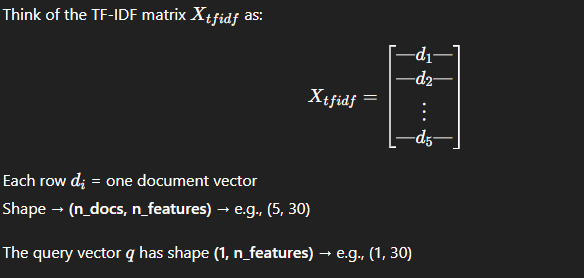

###  Cosine Similarity

Cosine similarity measures the angle between two vectors — how *aligned* they are in the same feature space.

**Per-document formula**

$$
\text{cosine}(d_i, q) = \frac{d_i \cdot q}{\|d_i\| \, \|q\|}
$$

**All documents at once (matrix form)**

$$
S = \frac{X_{\text{tfidf}} \, q^{\top}}{\|X_{\text{tfidf}}\| \, \|q\|}
$$

- **$X_{tfidf}$** → document–term matrix, shape **(n_docs × n_features)**  
- **$q^{T}$** → transposed query vector, shape **(n_features × 1)**

- Inner dimensions match → matrix multiplication is valid  
- **Output:** \(S\) has shape **(n_docs × 1)** (one similarity score per document)

👉 In scikit-learn, `cosine_similarity(X_tfidf, query_vec)` performs the transpose and normalization internally.


In [74]:
similarities = cosine_similarity(X_tfidf, query_vec).flatten()

print(similarities)

[0. 0. 0. 0. 0.]


In [ ]:
print(cosine_similarity(X_tfidf, query_vec).shape

(5, 1)


In [97]:
top_indices = np.argsort(-similarities)

for i in top_indices:
    print(f"Score: {similarities[i]:.3f} | Question: {sample_docs[i]}")

Score: 0.000 | Question: How to download CSV data via Jupyter NB and the Kaggle API, for one seamless experience
Score: 0.000 | Question: Get an error ‘Unable to locate credentials’ after running localstack with kinesis
Score: 0.000 | Question: GCP VM -  connect to host port 22 no route to host
Score: 0.000 | Question: Docker-Compose - docker-compose still not available after changing .bashrc
Score: 0.000 | Question: How to troubleshoot issues
